# Fashion Forge

# 1. Setting up Environment

In [ ]:
!pip install tensorflow tensorflow-gpu matplotlib tensorflow-datasets ipywidgets

  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [ ]:
import tensorflow as tf
print("Check my GPU", tf.config.list_physical_devices("GPU"))

Check my GPU [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print("GPU configured with memory growth")
else:
    print("No GPU detected")

GPU configured with memory growth


In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers

# 2. Import Dataset and Check it

### This loads the fashion MNIST dataset

(X_train, y_train) (X_test, y_test)

_ discards the test dataset because we only need the training images

Values between 0 and 255 → Different shades of gray

0   → Black
127 → Medium Gray
255 → White

In [13]:
(X_train, _), (_, _) = keras.datasets.cifar10.load_data()

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [14]:
print("Data shape",X_train.shape)

Data shape (50000, 32, 32, 3)


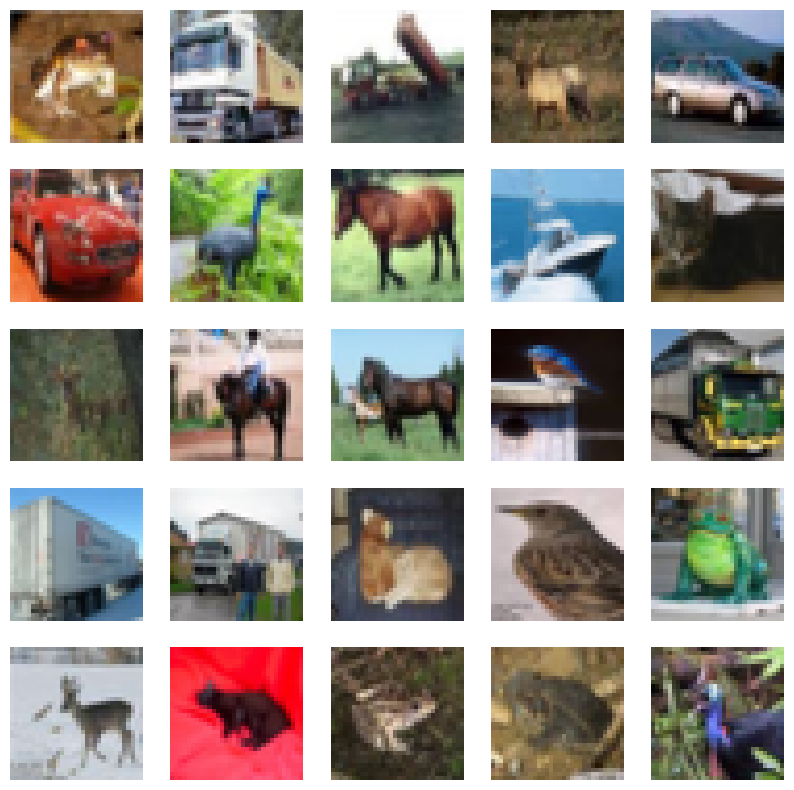

In [15]:
plt.figure(figsize=(10,10))
for i in range(25):
  plt.subplot(5, 5, i+1)
  plt.imshow(X_train[i], cmap="gray")
  plt.axis("off")
plt.show()

# 3. Create a Data Pipeline

In [19]:
X_train.shape[0]

50000

### Normalizing the data

X_train.shape[0] → Represents the number of images (60,000 in Fashion MNIST). 28, 28 → The images are 28×28 pixels (grayscale). 1 → The extra dimension is added to indicate one color channel (grayscale).

astype("float32") -> convert them to floating point numbers, which are needed for our neural network to work efficiently

X_train = (X_train - 127.5) / 127.5

The pixex value are originally stored as integer (0-255), GANs work better in the range [-1, 1] instead of [0, 255]

In [26]:
# Normalise and reshape the data
X_train = X_train.astype("float32")  # Convert to float32 for better performance
X_train = (X_train - 127.5) / 127.5  # Normalize pixel values to the range [-1, 1]

In [27]:
X_train.shape

(50000, 32, 32, 3)

BUFFER_SIZE = 60000:
Ensures complete shuffling of the dataset every epoch for diverse training.

BATCH_SIZE = 256:
Determines the number of images processed at once, balancing memory usage and training speed.

In [24]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [25]:
X_train

array([[[[-0.5372549 , -0.5137255 , -0.5058824 ],
         [-0.6627451 , -0.6392157 , -0.64705884],
         [-0.60784316, -0.62352943, -0.6627451 ],
         ...,
         [ 0.23921569,  0.03529412, -0.15294118],
         [ 0.19215687, -0.01960784, -0.2       ],
         [ 0.16078432, -0.02745098, -0.19215687]],

        [[-0.8745098 , -0.84313726, -0.84313726],
         [-1.        , -1.        , -1.        ],
         [-0.85882354, -0.9372549 , -1.        ],
         ...,
         [-0.03529412, -0.30980393, -0.5686275 ],
         [-0.06666667, -0.34901962, -0.60784316],
         [-0.04313726, -0.31764707, -0.5529412 ]],

        [[-0.8039216 , -0.8117647 , -0.8352941 ],
         [-0.8745098 , -0.94509804, -1.        ],
         [-0.6156863 , -0.7882353 , -0.9372549 ],
         ...,
         [-0.07450981, -0.34117648, -0.60784316],
         [-0.05882353, -0.34117648, -0.60784316],
         [-0.14509805, -0.42745098, -0.67058825]],

        ...,

        [[ 0.6313726 ,  0.33333334, -0

Before batching (60000, 28, 28, 1) -> 60,000 individual images

After batching (256, 28, 28, 1) Each batch contain 256 images

Total number of batch per epoch would be -> 60000/256 = 235

-> Coverting X_train into a Tensorflow dataset

-> Shuffles the dataset (to prevent order bias)

-> Batches the dataset into group of 256 images for efficient training

In [28]:
# Create the tensorflow dstaset
train_dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

mean=0.0 is commonly used in GANs, sometimes a small non-zero mean can improve stability.

Default → mean=0.0 (safe, but can be improved). Better choice → mean=0.01 or mean=0.02 for faster and more stable training.

Why stddev=0.02?

Based on research (from DCGAN paper), stddev=0.02 helps GANs generate sharper images. Ensures the network starts with balanced gradients.

In [29]:
LATENT_DIM = 100
WEIGHT_UNIT = keras.initializers.RandomNormal(mean=0.01, stddev=0.02)

# 4. Create a Generator and a Discriminator

In [30]:
def build_generator():
  model = keras.Sequential([
    layers.Dense(7*7*256, use_bias=False, input_shape=(LATENT_DIM,)),
    layers.BatchNormalization(), # normalize the activation of the previous layer
    layers.LeakyReLU(),

    layers.Reshape((7, 7, 256)),

    layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False),
    layers.BatchNormalization(),
    layers.LeakyReLU(0.2),

    layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False),
    layers.BatchNormalization(),
    layers.LeakyReLU(0.2),

    layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')
  ])
  return model

generator = build_generator()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [31]:
# build our discriminator
def build_discriminator():
  model = keras.Sequential([
      # First COnv2d layer: Detect low level features in the images (edges, textures, ...)
      layers.Conv2D(64, (5,5), strides=(2,2), padding='same', input_shape=[28,28,1]),

      # LeakyRelu activation function to avoid dead neurons and allow negative gradients
      layers.LeakyReLU(0.2),
      # dropout to prevent overfitting and improve generalization
      layers.Dropout(0.3),

      # First COnv2d layer: learn more complex feature from the images
      layers.Conv2D(128, (5,5), strides=(2,2), padding='same'),
      layers.LeakyReLU(0.2),
      layers.Dropout(0.3),

      # Flatten the 2D feature maps into a 1D vector for the Dense layer
      layers.Flatten(),

      layers.Dense(1, activation='sigmoid')

  ])

  return model

discriminator = build_discriminator()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [32]:
cross_entropy = keras.losses.BinaryCrossentropy()

### Create the generator amd discriminator losses

In [33]:
# Create the discriminator loss
def discriminator_loss(real_output, fake_output):
  # calculates the loss when the discriminator classify fake images
  real_loss = cross_entropy(tf.ones_like(real_output), real_output)

  #ccalculate the loss when the discriminator classifies fake images
  fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)

 # Return the sum of both losses
  return real_loss + fake_loss

In [34]:
def generator_loss(fake_output):
  return cross_entropy(tf.ones_like(fake_output), fake_output)

In [35]:
generator_optimizer = keras.optimizers.Adam(learning_rate=0.0002, beta_1 = 0.5)
discriminator_optimizer = keras.optimizers.Adam(learning_rate=0.0002, beta_1 = 0.5)

### Building a Sub class model

In [36]:
# Building our sub ckass model
class GAN(keras.Model):
  def __init__(self, generator, discriminator):
    # initilize the GAN model  with the generator and discriminator
    super(GAN, self).__init__()
    self.generator = generator #set genrator model
    self.discriminator = discriminator # set discriminator moel


  def compile(self, g_optimizer, d_optimizer, g_loss, d_loss):
    super(GAN, self).compile()
    self.g_optimizer = g_optimizer # set the generator optimizer
    self.d_optimizer = d_optimizer # set the discriminator optimizer
    self.g_loss = g_loss # set the generator loss
    self.d_loss = d_loss # set the discriminator loss


  def train_step(self, real_images):
    # Training logic
    batch_size = tf.shape(real_images)[0]

    # Train discriminator
    noise = tf.random.normal([batch_size, LATENT_DIM])
    with tf.GradientTape() as d_tape:
        generated_images = self.generator(noise)
        real_output = self.discriminator(real_images)
        fake_output = self.discriminator(generated_images)
        d_loss = self.d_loss(real_output, fake_output)

    # Cimputing the gradients for the discriminator based in its loss
    d_gradients = d_tape.gradient(d_loss, self.discriminator.trainable_variables)
    self.d_optimizer.apply_gradients(zip(d_gradients, self.discriminator.trainable_variables))

    # Train generator
    noise = tf.random.normal([batch_size, LATENT_DIM])
    with tf.GradientTape() as g_tape:
        generated_images = self.generator(noise)
        fake_output = self.discriminator(generated_images)
        g_loss = self.g_loss(fake_output)

    g_gradients = g_tape.gradient(g_loss, self.generator.trainable_variables)
    self.g_optimizer.apply_gradients(zip(g_gradients, self.generator.trainable_variables))

    return {"d_loss": d_loss, "g_loss": g_loss}

In [37]:
class ImageCallback(keras.callbacks.Callback):
  def __init__(self, num_images=16, latent_dim=100):
    self.num_images = num_images
    self.latent_dim = latent_dim
    self.seed = tf.random.normal([num_images, latent_dim])

  def on_epoch_end(self, epoch, logs=None):
    if epoch % 5 == 0:
      generated_images = self.model.generator(self.seed)
      generated_images = (generated_images * 127.5) + 127.5 #rescaleto range [0, 233]

      plt.figure(figsize=(10,10))
      for i in range(self.num_images):
        plt.subplot(4, 4, i+1)
        plt.imshow(generated_images[i].numpy().astype("uint8"), cmap="gray")
        plt.axis("off")
      plt.show()

# 5. Train the Dataset

In [38]:
EPOCH = 100

In [42]:
# build our discriminator
def build_discriminator():
  model = keras.Sequential([
      # First COnv2d layer: Detect low level features in the images (edges, textures, ...)
      layers.Conv2D(64, (5,5), strides=(2,2), padding='same',
                    input_shape=[32,32,3]), # Changed input_shape to match CIFAR-10

      # LeakyRelu activation function to avoid dead neurons and allow negative gradients
      layers.LeakyReLU(0.2),
      # dropout to prevent overfitting and improve generalization
      layers.Dropout(0.3),

      # First COnv2d layer: learn more complex feature from the images
      layers.Conv2D(128, (5,5), strides=(2,2), padding='same'),
      layers.LeakyReLU(0.2),
      layers.Dropout(0.3),

      # Flatten the 2D feature maps into a 1D vector for the Dense layer
      layers.Flatten(),

      layers.Dense(1, activation='sigmoid')

  ])

  return model

discriminator = build_discriminator()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [51]:
def build_generator():
    model = keras.Sequential([
        layers.Dense(8 * 8 * 256, use_bias=False, input_shape=(LATENT_DIM,)),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        layers.Reshape((8, 8, 256)),  # Reshape to a larger size

        layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(0.2),

        layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(0.2),

        layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')
    ])
    return model

# Recreate the generator object
generator = build_generator()

# Recreate the GAN object (important!)
gan = GAN(generator=generator, discriminator=discriminator)

# Recompile the GAN
gan.compile(
    g_optimizer=generator_optimizer,
    d_optimizer=discriminator_optimizer,
    g_loss=generator_loss,
    d_loss=discriminator_loss
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - d_loss: 1.2572 - g_loss: 0.7395

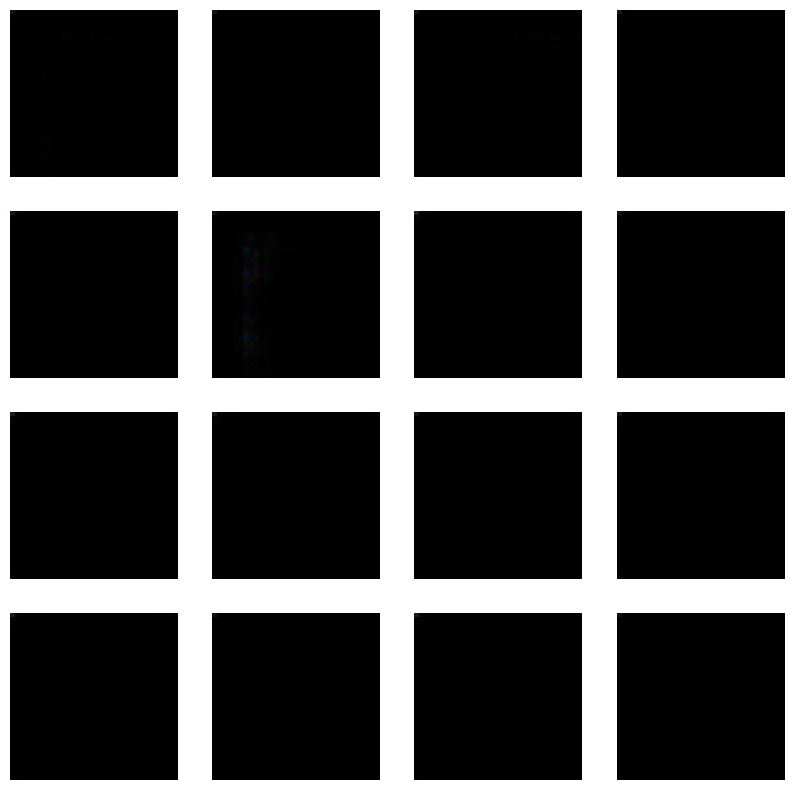

196/196 ━━━━━━━━━━━━━━━━━━━━ 26s 79ms/step - d_loss: 1.2583 - g_loss: 0.7403
Epoch 2/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 11s 52ms/step - d_loss: 1.3854 - g_loss: 0.6936
Epoch 3/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 10s 52ms/step - d_loss: 1.3879 - g_loss: 0.6940
Epoch 4/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - d_loss: 1.3865 - g_loss: 0.6931
Epoch 5/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 21s 54ms/step - d_loss: 1.3867 - g_loss: 0.6933
Epoch 6/100
195/196 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - d_loss: 1.3860 - g_loss: 0.6933

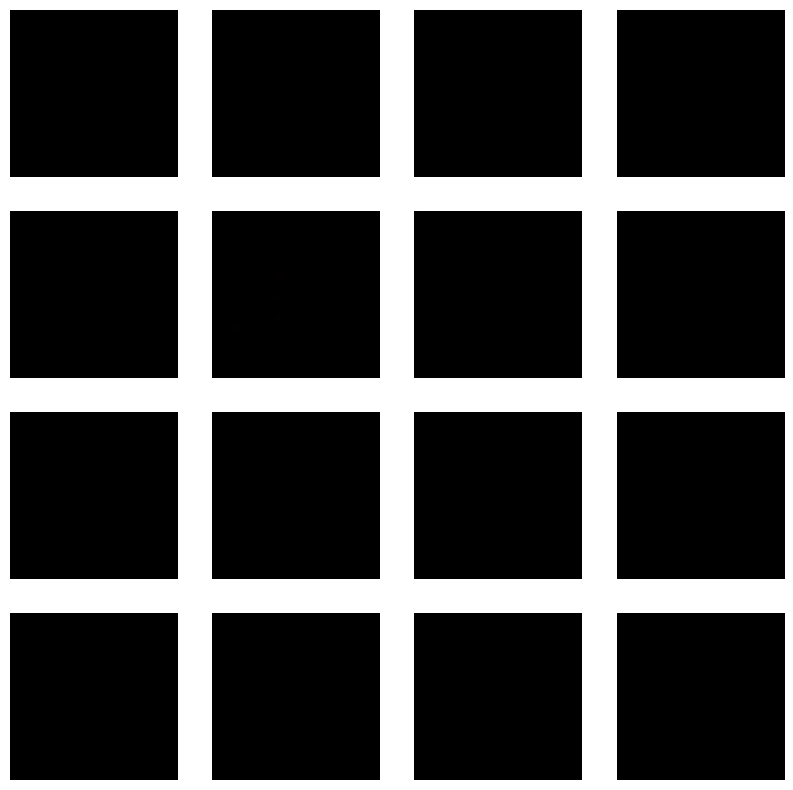

196/196 ━━━━━━━━━━━━━━━━━━━━ 11s 56ms/step - d_loss: 1.3860 - g_loss: 0.6932
Epoch 7/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 20s 54ms/step - d_loss: 1.3861 - g_loss: 0.6935
Epoch 8/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 11s 55ms/step - d_loss: 1.3860 - g_loss: 0.6936
Epoch 9/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 11s 55ms/step - d_loss: 1.3858 - g_loss: 0.6935
Epoch 10/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 11s 54ms/step - d_loss: 1.3857 - g_loss: 0.6937
Epoch 11/100
195/196 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - d_loss: 1.3859 - g_loss: 0.6939

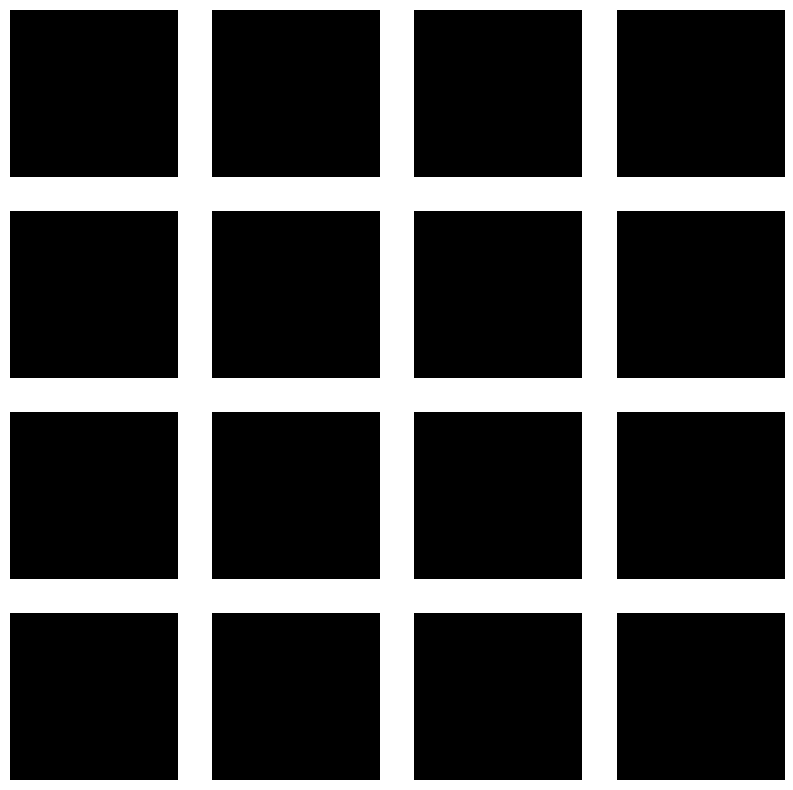

196/196 ━━━━━━━━━━━━━━━━━━━━ 11s 57ms/step - d_loss: 1.3859 - g_loss: 0.6939
Epoch 12/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 11s 53ms/step - d_loss: 1.3854 - g_loss: 0.6939
Epoch 13/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 11s 53ms/step - d_loss: 1.3850 - g_loss: 0.6942
Epoch 14/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 11s 53ms/step - d_loss: 1.3860 - g_loss: 0.6959
Epoch 15/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 21s 54ms/step - d_loss: 1.3851 - g_loss: 0.6939
Epoch 16/100
195/196 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - d_loss: 1.3859 - g_loss: 0.6957

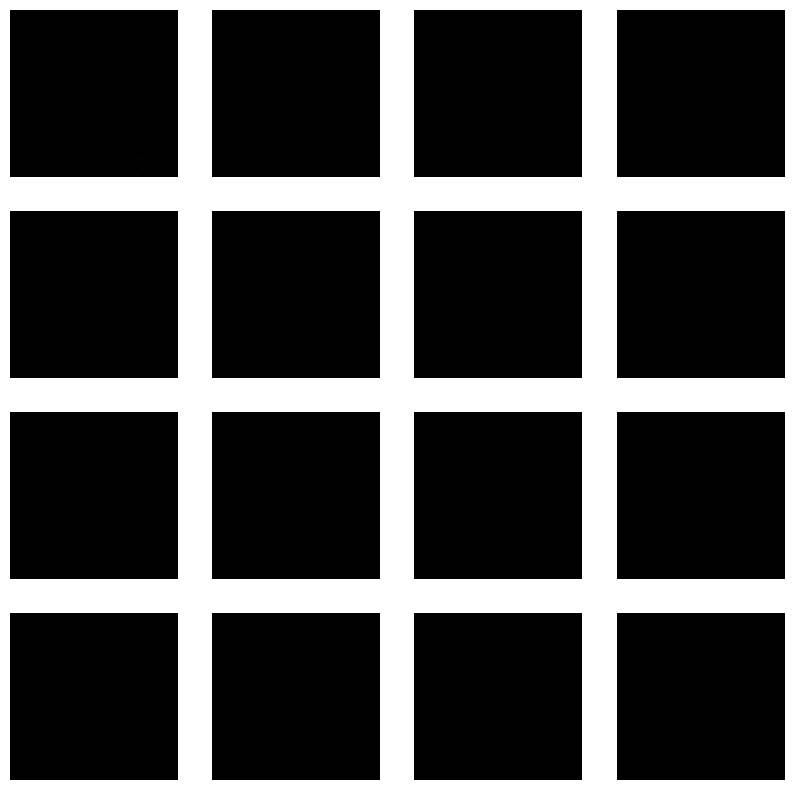

196/196 ━━━━━━━━━━━━━━━━━━━━ 21s 55ms/step - d_loss: 1.3858 - g_loss: 0.6957
Epoch 17/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 11s 55ms/step - d_loss: 1.3843 - g_loss: 0.6940
Epoch 18/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 11s 55ms/step - d_loss: 1.3839 - g_loss: 0.6952
Epoch 19/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 20s 54ms/step - d_loss: 1.3833 - g_loss: 0.6959
Epoch 20/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 20s 54ms/step - d_loss: 1.3813 - g_loss: 0.6958
Epoch 21/100
195/196 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - d_loss: 1.3981 - g_loss: 0.7228

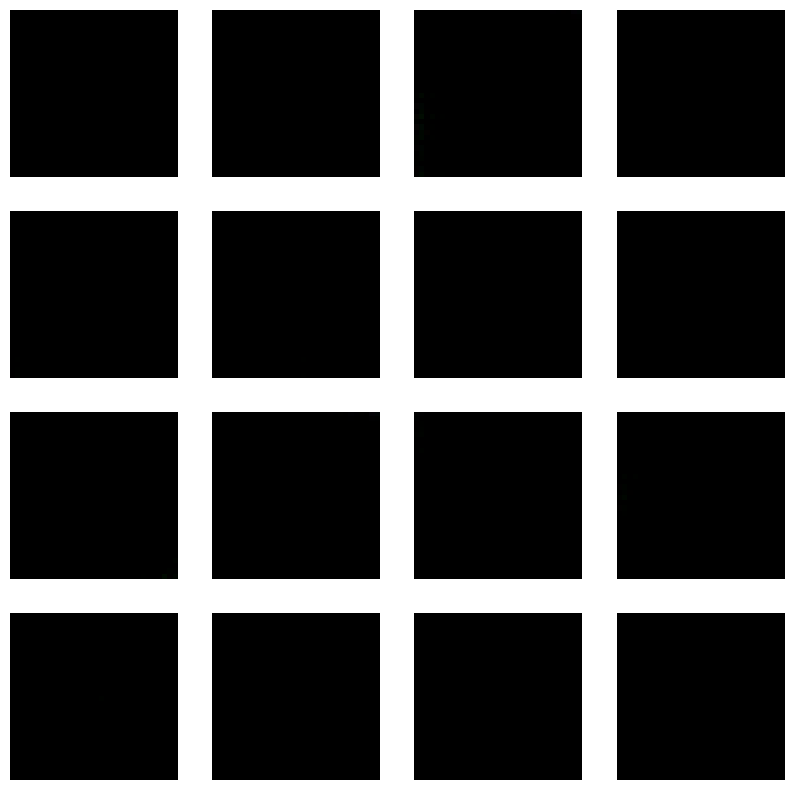

196/196 ━━━━━━━━━━━━━━━━━━━━ 11s 56ms/step - d_loss: 1.3980 - g_loss: 0.7225
Epoch 22/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 11s 55ms/step - d_loss: 1.3860 - g_loss: 0.6927
Epoch 23/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 20s 54ms/step - d_loss: 1.3860 - g_loss: 0.6932
Epoch 24/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 20s 54ms/step - d_loss: 1.3860 - g_loss: 0.6947
Epoch 25/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 21s 54ms/step - d_loss: 1.3850 - g_loss: 0.6935
Epoch 26/100
195/196 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - d_loss: 1.3853 - g_loss: 0.6939

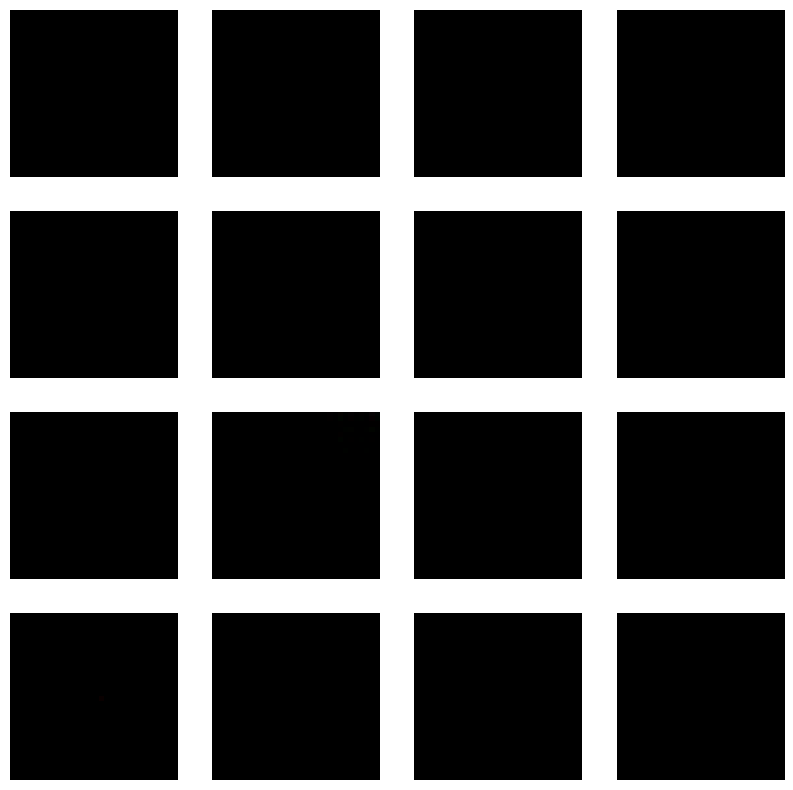

196/196 ━━━━━━━━━━━━━━━━━━━━ 21s 56ms/step - d_loss: 1.3853 - g_loss: 0.6939
Epoch 27/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 20s 54ms/step - d_loss: 1.3860 - g_loss: 0.6936
Epoch 28/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 20s 54ms/step - d_loss: 1.3862 - g_loss: 0.6932
Epoch 29/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 11s 54ms/step - d_loss: 1.3862 - g_loss: 0.6932
Epoch 30/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 20s 54ms/step - d_loss: 1.3863 - g_loss: 0.6930
Epoch 31/100
195/196 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - d_loss: 1.3856 - g_loss: 0.6934

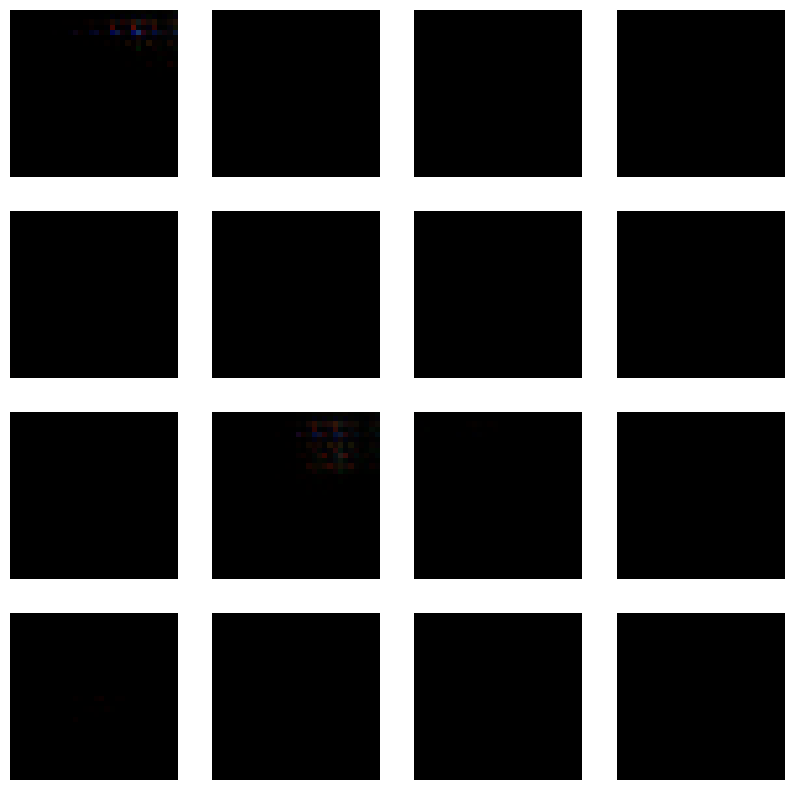

196/196 ━━━━━━━━━━━━━━━━━━━━ 21s 55ms/step - d_loss: 1.3856 - g_loss: 0.6934
Epoch 32/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 11s 55ms/step - d_loss: 1.3861 - g_loss: 0.6930
Epoch 33/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 11s 55ms/step - d_loss: 1.3861 - g_loss: 0.6931
Epoch 34/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 11s 54ms/step - d_loss: 1.3861 - g_loss: 0.6925
Epoch 35/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 20s 53ms/step - d_loss: 1.3860 - g_loss: 0.6934
Epoch 36/100
195/196 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - d_loss: 1.3862 - g_loss: 0.6929

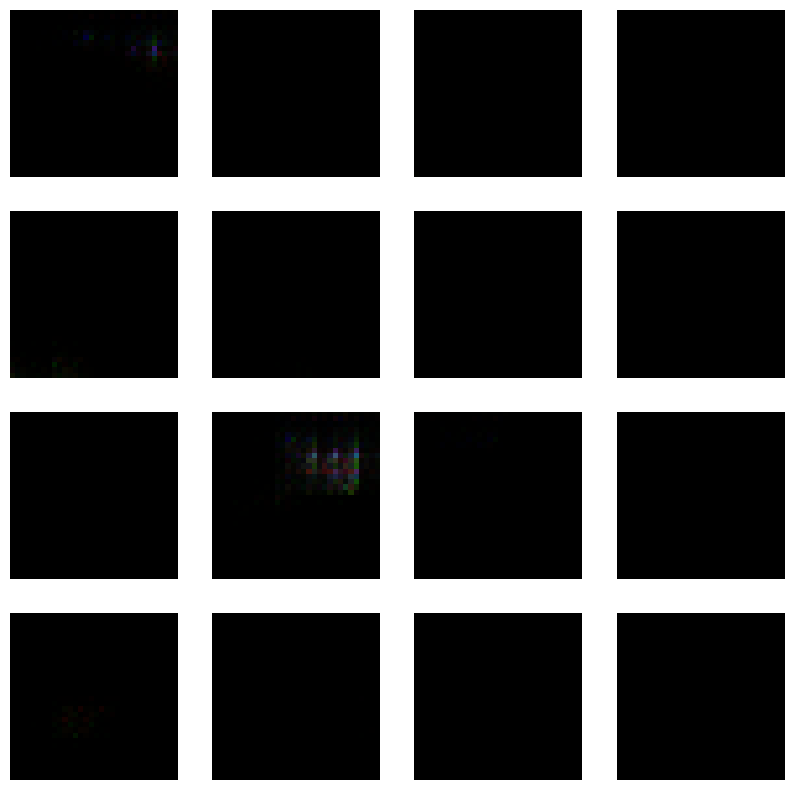

196/196 ━━━━━━━━━━━━━━━━━━━━ 11s 55ms/step - d_loss: 1.3862 - g_loss: 0.6928
Epoch 37/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 11s 54ms/step - d_loss: 1.3861 - g_loss: 0.6930
Epoch 38/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 20s 54ms/step - d_loss: 1.3863 - g_loss: 0.6930
Epoch 39/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 11s 54ms/step - d_loss: 1.3859 - g_loss: 0.6930
Epoch 40/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 20s 54ms/step - d_loss: 1.3861 - g_loss: 0.6928
Epoch 41/100
195/196 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - d_loss: 1.3860 - g_loss: 0.6929

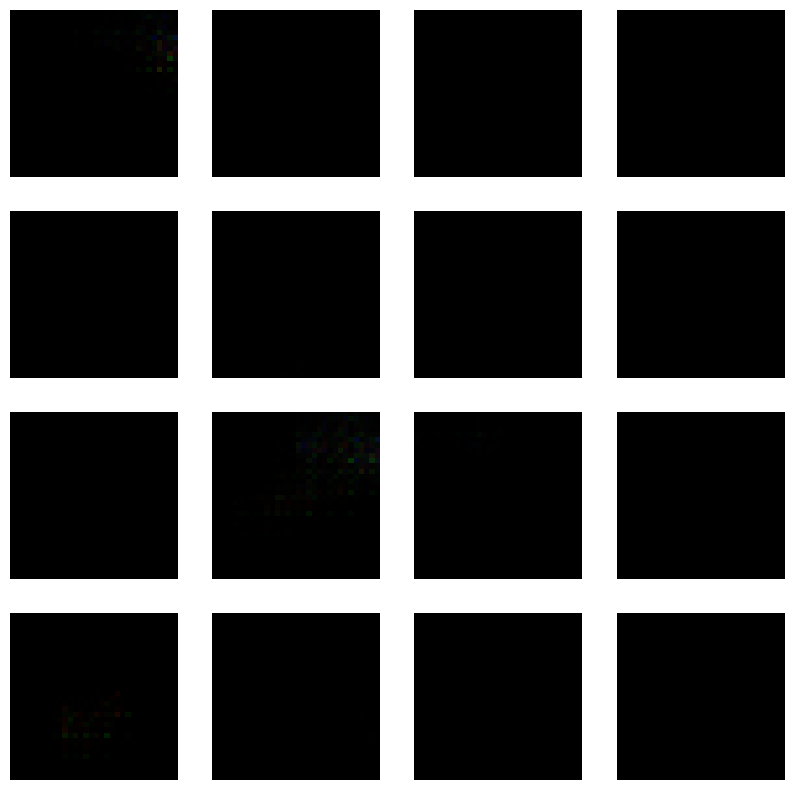

196/196 ━━━━━━━━━━━━━━━━━━━━ 11s 57ms/step - d_loss: 1.3860 - g_loss: 0.6929
Epoch 42/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 11s 54ms/step - d_loss: 1.3861 - g_loss: 0.6928
Epoch 43/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 11s 54ms/step - d_loss: 1.3861 - g_loss: 0.6929
Epoch 44/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 11s 54ms/step - d_loss: 1.3861 - g_loss: 0.6929
Epoch 45/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 10s 53ms/step - d_loss: 1.3863 - g_loss: 0.6929
Epoch 46/100
195/196 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - d_loss: 1.3861 - g_loss: 0.6929

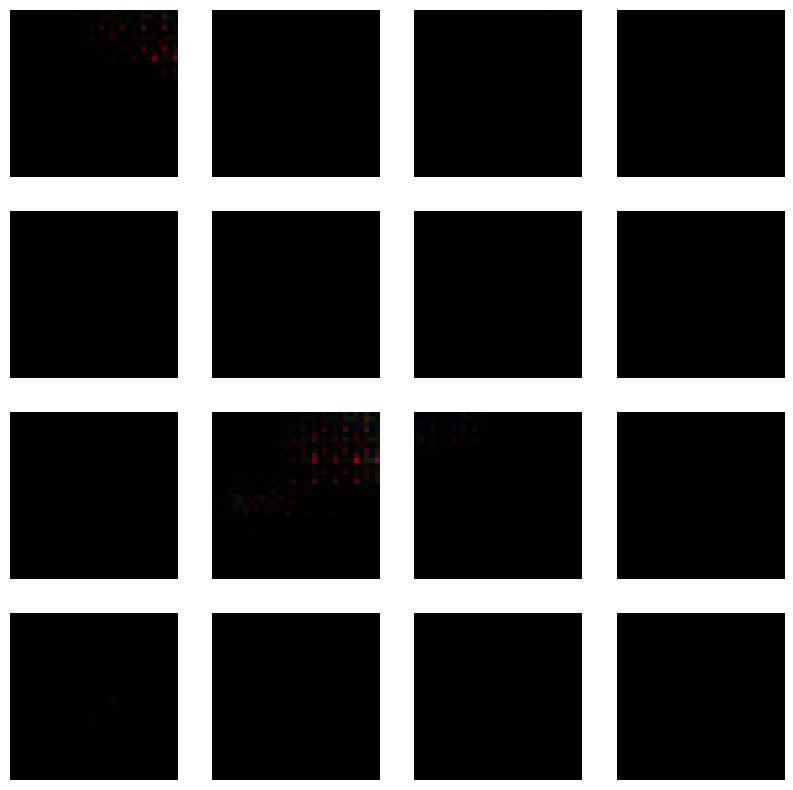

196/196 ━━━━━━━━━━━━━━━━━━━━ 11s 55ms/step - d_loss: 1.3861 - g_loss: 0.6929
Epoch 47/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 11s 53ms/step - d_loss: 1.3864 - g_loss: 0.6929
Epoch 48/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 20s 53ms/step - d_loss: 1.3861 - g_loss: 0.6927
Epoch 49/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 11s 54ms/step - d_loss: 1.3861 - g_loss: 0.6929
Epoch 50/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 11s 55ms/step - d_loss: 1.3860 - g_loss: 0.6929
Epoch 51/100
195/196 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - d_loss: 1.3862 - g_loss: 0.6931

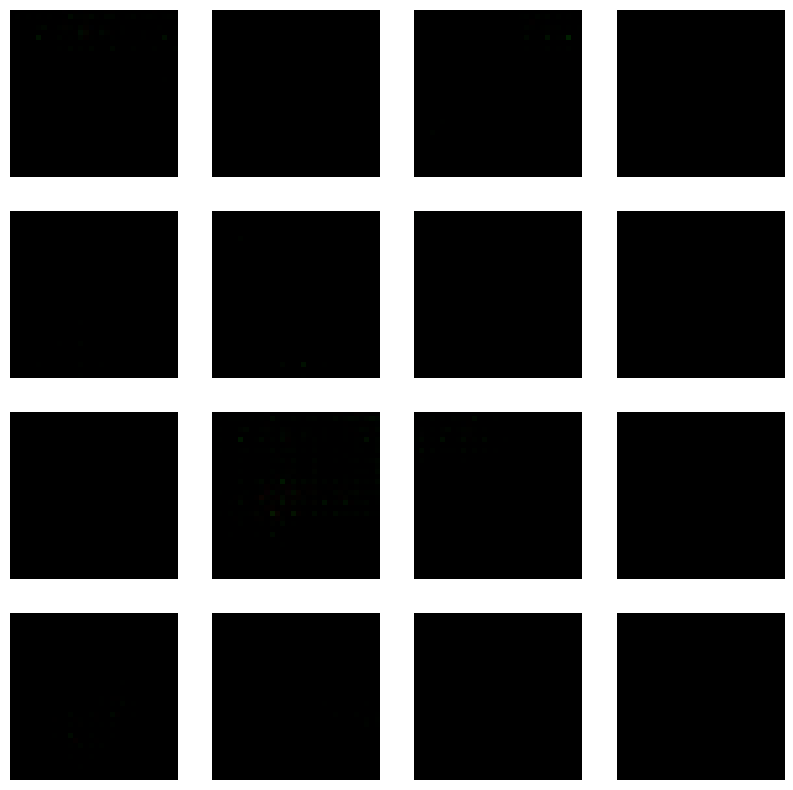

196/196 ━━━━━━━━━━━━━━━━━━━━ 11s 56ms/step - d_loss: 1.3861 - g_loss: 0.6931
Epoch 52/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 11s 54ms/step - d_loss: 1.3859 - g_loss: 0.6929
Epoch 53/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 20s 53ms/step - d_loss: 1.3860 - g_loss: 0.6930
Epoch 54/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 11s 53ms/step - d_loss: 1.3863 - g_loss: 0.6931
Epoch 55/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 11s 54ms/step - d_loss: 1.3862 - g_loss: 0.6933
Epoch 56/100
195/196 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - d_loss: 1.3864 - g_loss: 0.6933

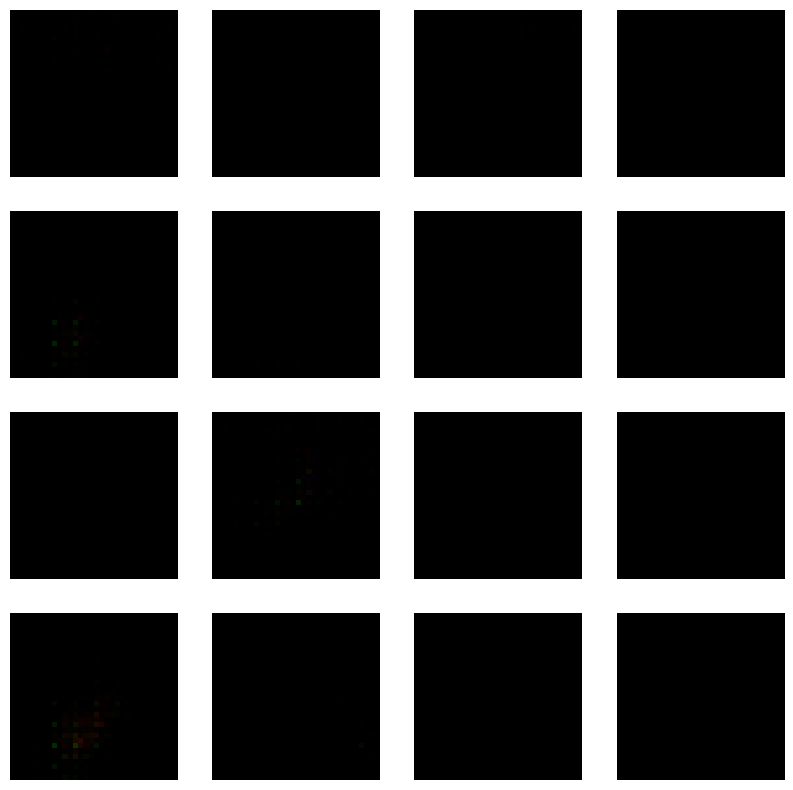

196/196 ━━━━━━━━━━━━━━━━━━━━ 11s 56ms/step - d_loss: 1.3864 - g_loss: 0.6932
Epoch 57/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 11s 54ms/step - d_loss: 1.3859 - g_loss: 0.6930
Epoch 58/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 11s 54ms/step - d_loss: 1.3859 - g_loss: 0.6930
Epoch 59/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 11s 53ms/step - d_loss: 1.3862 - g_loss: 0.6931
Epoch 60/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 20s 53ms/step - d_loss: 1.3859 - g_loss: 0.6933
Epoch 61/100
195/196 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - d_loss: 1.3887 - g_loss: 0.6944

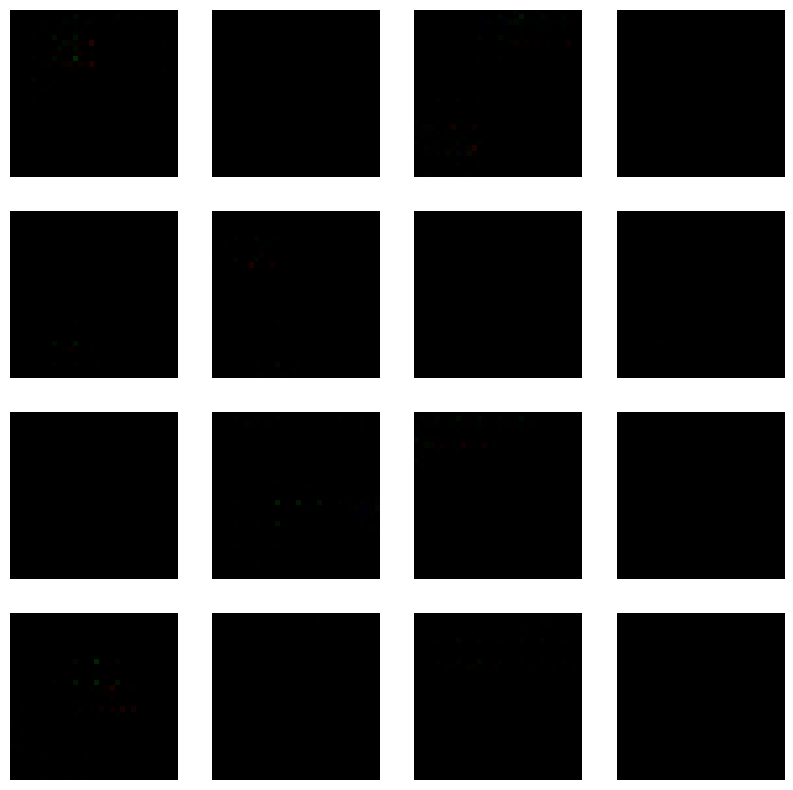

196/196 ━━━━━━━━━━━━━━━━━━━━ 11s 55ms/step - d_loss: 1.3887 - g_loss: 0.6943
Epoch 62/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 11s 55ms/step - d_loss: 1.3862 - g_loss: 0.6928
Epoch 63/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 20s 54ms/step - d_loss: 1.3861 - g_loss: 0.6927
Epoch 64/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 11s 54ms/step - d_loss: 1.3861 - g_loss: 0.6928
Epoch 65/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 11s 54ms/step - d_loss: 1.3860 - g_loss: 0.6929
Epoch 66/100
195/196 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - d_loss: 1.3862 - g_loss: 0.6930

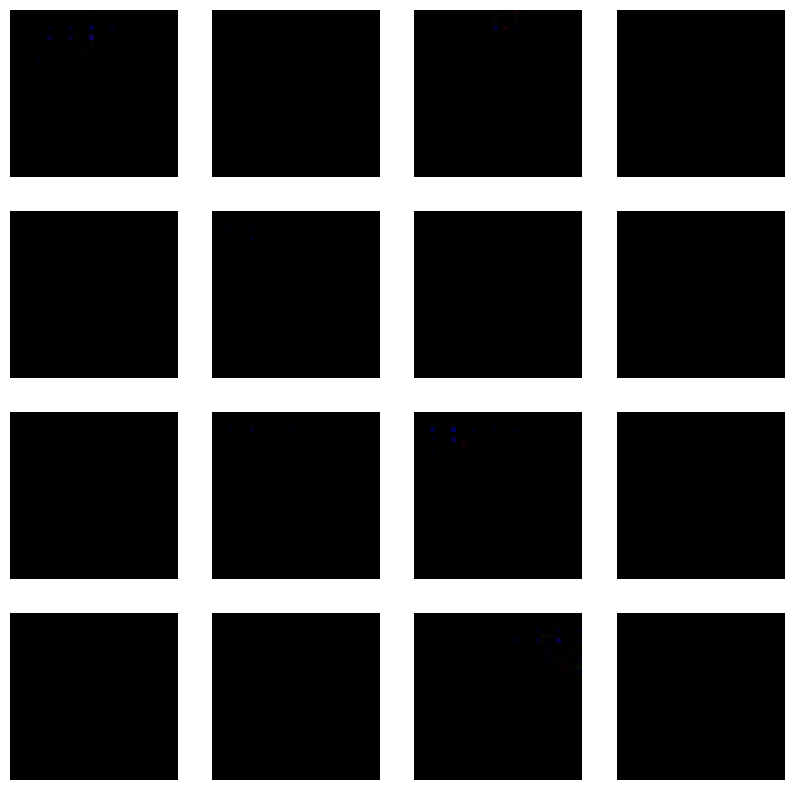

196/196 ━━━━━━━━━━━━━━━━━━━━ 21s 55ms/step - d_loss: 1.3862 - g_loss: 0.6930
Epoch 67/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 11s 54ms/step - d_loss: 1.3860 - g_loss: 0.6930
Epoch 68/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 11s 54ms/step - d_loss: 1.3860 - g_loss: 0.6929
Epoch 69/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 11s 54ms/step - d_loss: 1.3864 - g_loss: 0.6931
Epoch 70/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 11s 54ms/step - d_loss: 1.3858 - g_loss: 0.6931
Epoch 71/100
195/196 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - d_loss: 1.3859 - g_loss: 0.6931

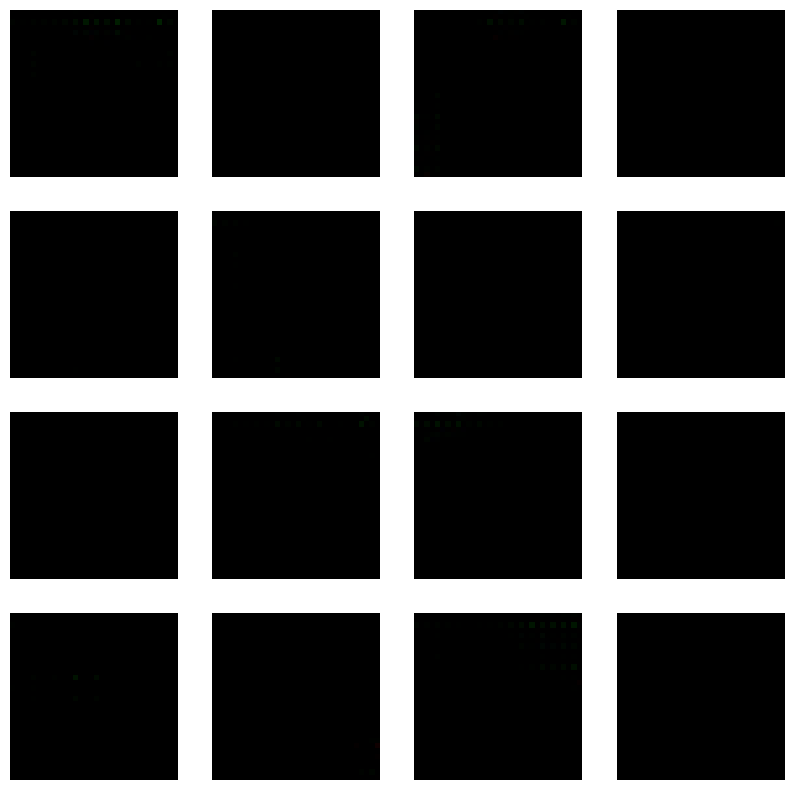

196/196 ━━━━━━━━━━━━━━━━━━━━ 11s 55ms/step - d_loss: 1.3859 - g_loss: 0.6931
Epoch 72/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 11s 53ms/step - d_loss: 1.3859 - g_loss: 0.6931
Epoch 73/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 20s 53ms/step - d_loss: 1.3858 - g_loss: 0.6932
Epoch 74/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 21s 54ms/step - d_loss: 1.3878 - g_loss: 0.6944
Epoch 75/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 21s 55ms/step - d_loss: 1.3860 - g_loss: 0.6929
Epoch 76/100
195/196 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - d_loss: 1.3860 - g_loss: 0.6931

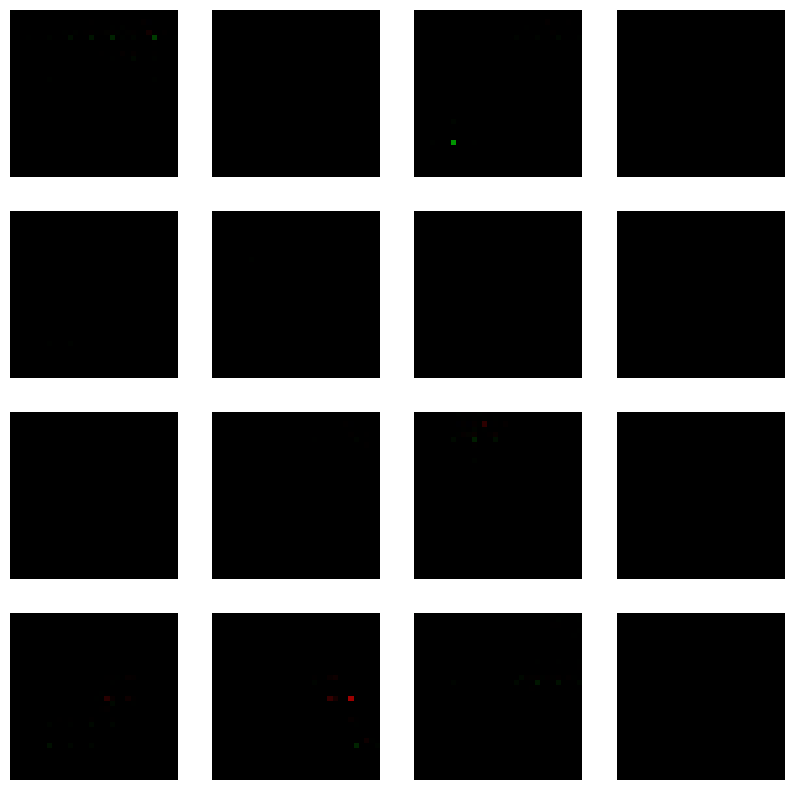

196/196 ━━━━━━━━━━━━━━━━━━━━ 11s 58ms/step - d_loss: 1.3860 - g_loss: 0.6930
Epoch 77/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 11s 54ms/step - d_loss: 1.3860 - g_loss: 0.6930
Epoch 78/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 11s 54ms/step - d_loss: 1.3858 - g_loss: 0.6933
Epoch 79/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 20s 53ms/step - d_loss: 1.3860 - g_loss: 0.6939
Epoch 80/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 11s 53ms/step - d_loss: 1.3863 - g_loss: 0.6933
Epoch 81/100
195/196 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - d_loss: 1.3858 - g_loss: 0.6932

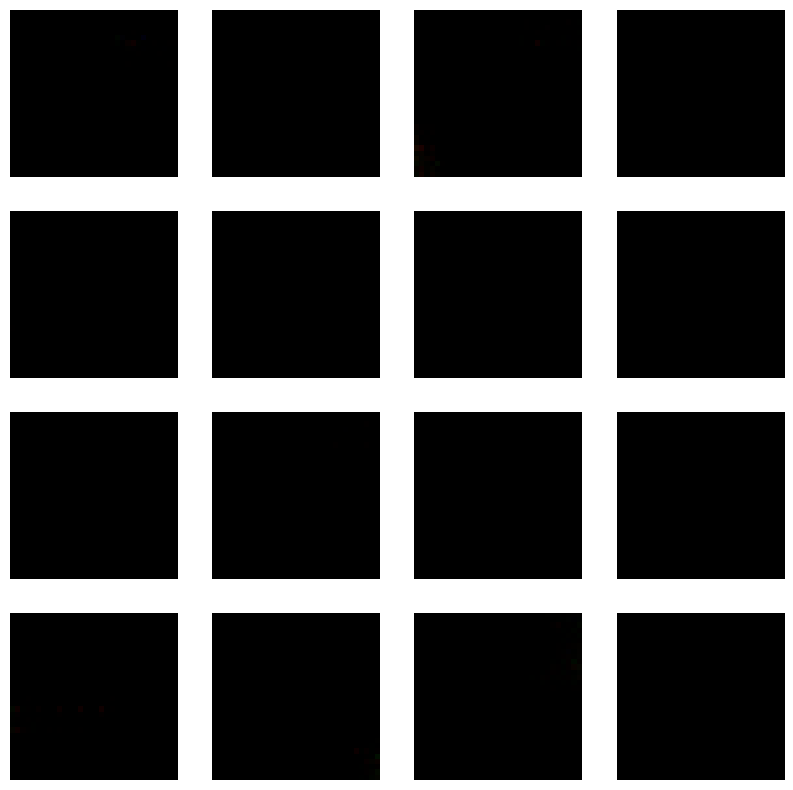

196/196 ━━━━━━━━━━━━━━━━━━━━ 21s 55ms/step - d_loss: 1.3858 - g_loss: 0.6932
Epoch 82/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 11s 55ms/step - d_loss: 1.3858 - g_loss: 0.6933
Epoch 83/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 20s 54ms/step - d_loss: 1.3859 - g_loss: 0.6934
Epoch 84/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 11s 54ms/step - d_loss: 1.3862 - g_loss: 0.6935
Epoch 85/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 11s 54ms/step - d_loss: 1.3856 - g_loss: 0.6933
Epoch 86/100
195/196 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - d_loss: 1.3859 - g_loss: 0.6936

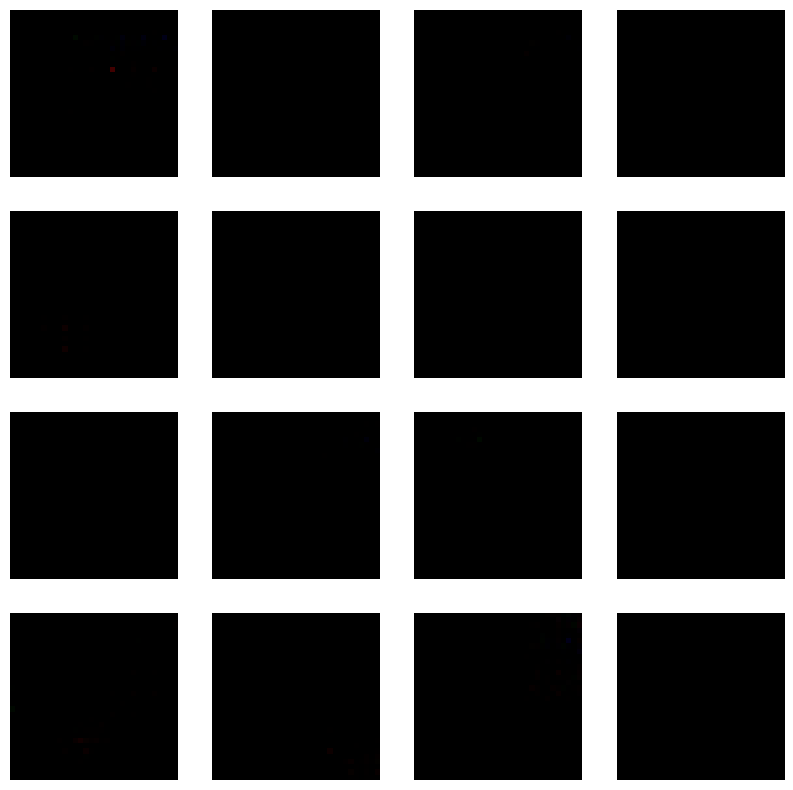

196/196 ━━━━━━━━━━━━━━━━━━━━ 21s 55ms/step - d_loss: 1.3859 - g_loss: 0.6936
Epoch 87/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 11s 54ms/step - d_loss: 1.3930 - g_loss: 0.6969
Epoch 88/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 11s 55ms/step - d_loss: 1.3862 - g_loss: 0.6929
Epoch 89/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 20s 54ms/step - d_loss: 1.3860 - g_loss: 0.6930
Epoch 90/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 11s 54ms/step - d_loss: 1.3860 - g_loss: 0.6931
Epoch 91/100
195/196 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - d_loss: 1.3861 - g_loss: 0.6929

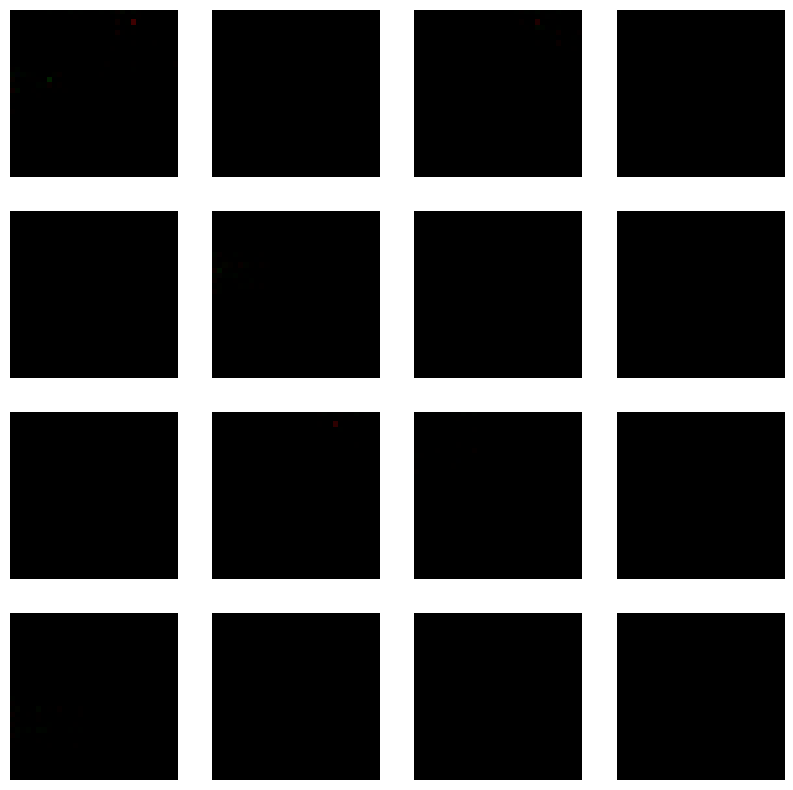

196/196 ━━━━━━━━━━━━━━━━━━━━ 21s 55ms/step - d_loss: 1.3861 - g_loss: 0.6929
Epoch 92/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 11s 54ms/step - d_loss: 1.3858 - g_loss: 0.6932
Epoch 93/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 11s 54ms/step - d_loss: 1.3858 - g_loss: 0.6934
Epoch 94/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 11s 54ms/step - d_loss: 1.3859 - g_loss: 0.6930
Epoch 95/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 20s 53ms/step - d_loss: 1.3858 - g_loss: 0.6930
Epoch 96/100
195/196 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - d_loss: 1.3858 - g_loss: 0.6936

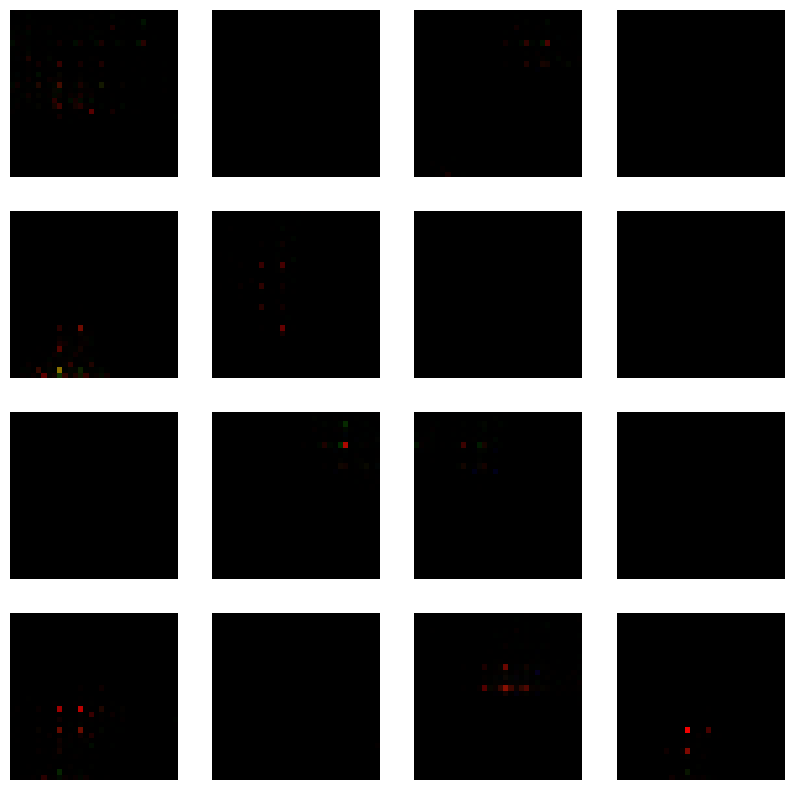

196/196 ━━━━━━━━━━━━━━━━━━━━ 11s 55ms/step - d_loss: 1.3858 - g_loss: 0.6938
Epoch 97/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 11s 55ms/step - d_loss: 1.3856 - g_loss: 0.6934
Epoch 98/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 20s 54ms/step - d_loss: 1.3860 - g_loss: 0.6935
Epoch 99/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 20s 54ms/step - d_loss: 1.3859 - g_loss: 0.6930
Epoch 100/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 20s 54ms/step - d_loss: 1.3856 - g_loss: 0.6935


In [52]:
# ipython-input-41-9df3df1e6c68
history = gan.fit(train_dataset, epochs=EPOCH, callbacks=[ImageCallback()]) # Assign the result of gan.fit() to history

# 6. Evaluate the model and save it

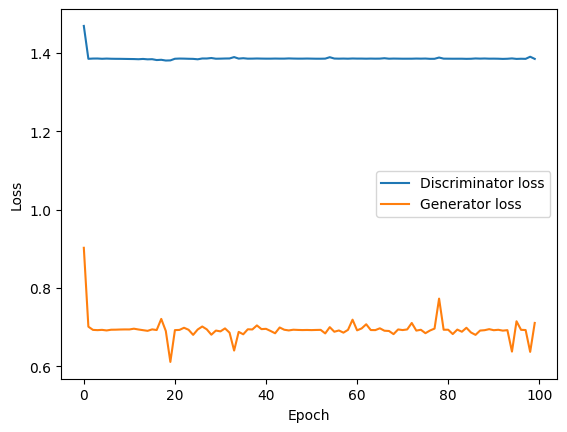

In [53]:
plt.plot(history.history['d_loss'], label='Discriminator loss')
plt.plot(history.history['g_loss'], label='Generator loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [54]:
# Test the generator
noise = tf.random.normal([25, LATENT_DIM])
generated_images = generator(noise)
generated_images = (generated_images * 127.5) + 127.5 # denormalize

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.11/dist-packages/matplotlib/pyplot.py'>

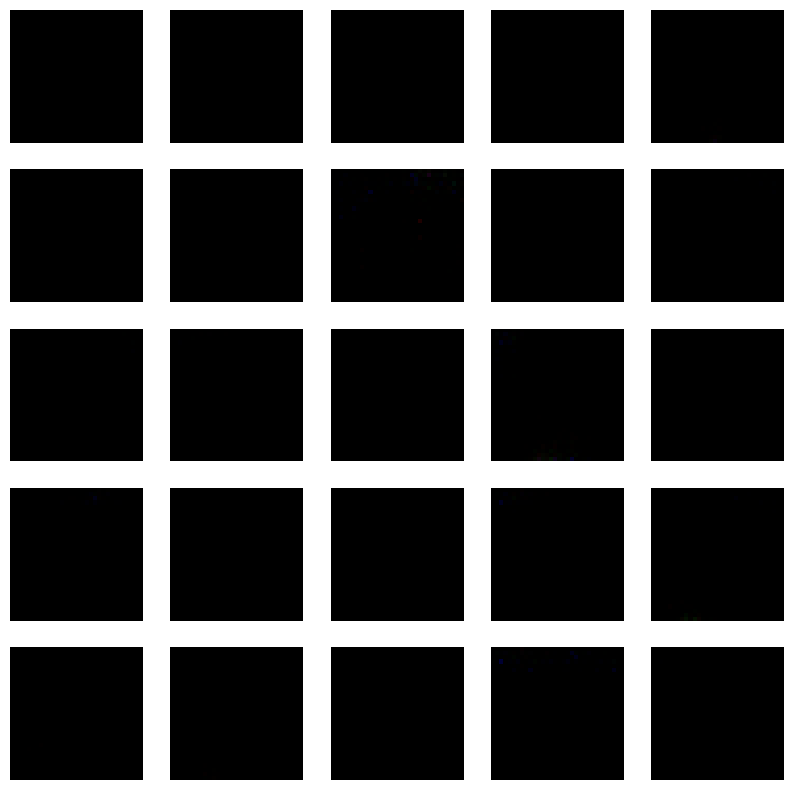

In [55]:
plt.figure(figsize=(10,10))
for i in range(25):
  plt.subplot(5, 5, i+1)
  plt.imshow(generated_images[i].numpy().astype("uint8"), cmap="gray")
  plt.axis("off")
plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [57]:
generator.save("/content/drive/My Drive/fashion_gan_generator.h5")